# Project name: Proverb Generator

## Project author: Lyuboslav Krastev

## Section I: Generate Bulgarian proverbs

### Preface

Recently I found myself browsing Bulgarian proverbs from A-Z and thinking that we have too few of those. Thus I decided to expand the list by attempting to generate some new ones through machine learning. I built the dataset by using the most extensive list of Bulgarian proverbs I found online. <br>
Source: https://bg.wikiquote.org/wiki/Български_пословици_и_поговорки

#### Import dependencies

In [1]:
import io
import re
import numpy as np
import pandas as pd
import string

from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Embedding, Concatenate, Flatten, LSTM, Dropout, Reshape, Activation,Bidirectional,Layer
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import optimizers,activations,initializers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import TensorBoard

### Data pre-processing

#### Read the dataset and check the number of characters in the corpus

In [2]:
with io.open('./data/bg_proverbs.txt', encoding='utf-8') as f:
    text = f.read().lower().replace('\n', ' \n ')
print('Corpus number of characters:', len(text))

Corpus number of characters: 30896


#### Check the number of words in the corpus

In [3]:
words = [w for w in text.split(' ') if w.strip() != '' or w == '\n']
print('Corpus number of words:', len(words))

Corpus number of words: 6251


There are 827 proverbs in the dataset.

#### Visualise the most common words

In [4]:
word_df = pd.DataFrame(words,columns=['word'])
top = word_df.word.value_counts().head(10)
print(top)

\n      826
не      212
се      181
да      145
и       112
е       104
на       97
като     75
си       70
от       64
Name: word, dtype: int64


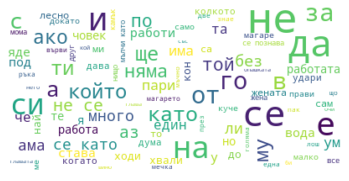

In [5]:
wc = WordCloud(background_color="white", max_words=100,
               max_font_size=50, random_state=42)
output = wc.generate(text)
plt.figure()
plt.imshow(output,interpolation='bilinear')
plt.axis('off')
plt.show()

Most of the words that can be observed above are actually stop words, however since I am performing text generation I will not be removing them. It is crucial to have these tokens when the goal is to generate text. <br>
Source: https://medium.com/@limavallantin/why-is-removing-stop-words-not-always-a-good-idea-c8d35bd77214

#### Remove punctuations

In [6]:
text = re.sub('\[,.*?“”…\]', '', text)

#### Convert the text into input sequences

In [7]:
# set the seed for reproducible results
tf.compat.v1.set_random_seed(64)

tokenizer = Tokenizer()

corpus = [w for w in text.split('\n') 
          if w.strip() != '' or w == '\n']

tokenizer.fit_on_texts(corpus)
TOTAL_WORDS = len(tokenizer.word_index)+1
input_seq = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1,len(token_list)):
        n_gram_seq = token_list[:i+1]
        input_seq.append(n_gram_seq)

MAX_SEQ_LEN = max([len(x) for x in input_seq])

input_sequences = np.array(pad_sequences(input_seq,
                           maxlen=MAX_SEQ_LEN, padding='pre'))
xs = input_sequences[:,:-1]
labels = input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels, num_classes=TOTAL_WORDS)

## Model selection

#### Objective: Build and select a model for Bulgarian proverb generation

I decided to use an LSTM, as it is said to be the most efficient in text generation and it has an acceptable loss amount.
Soruce: https://arxiv.org/ftp/arxiv/papers/1908/1908.04332.pdf

##### Why I chose BiLSTM

Bidirectional networks have access to the past as well as the future information and hence the output is generated from both the past and future context. As far as I understand, they have a better understanding of the context than unidirectional networks and yield better results.
To predict the next word in a sentence, it is often useful to have the context around the word, not only just the words that come before it.

I will be using softmax activation to compute the probability of the output class, because it is appropriate for multinomial mutually exclusive classification.

#### Single Bidirectional LSTM layer model 300 epochs 128 units 0.001 LR

In [8]:
single_bilstm_model = Sequential([
    Embedding(TOTAL_WORDS, 128, input_length=MAX_SEQ_LEN-1),
    Dropout(.5),
    Bidirectional(LSTM(128,return_sequences=False, kernel_initializer='random_uniform')),
    Dropout(.5),
    Dense(TOTAL_WORDS, activation='softmax')
])

single_bilstm_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.001),
              metrics=['accuracy'])
single_bilstm_model.fit(xs,ys,epochs=300,verbose=1, callbacks = [TensorBoard()])

single_bilstm_model.summary()

Epoch 1/300
145/145 [==============================] - 7s 22ms/step - loss: 7.0815 - accuracy: 0.0337
Epoch 2/300
145/145 [==============================] - 2s 15ms/step - loss: 6.4347 - accuracy: 0.0413
Epoch 3/300
145/145 [==============================] - 2s 14ms/step - loss: 6.3372 - accuracy: 0.0404
Epoch 4/300
145/145 [==============================] - 2s 14ms/step - loss: 6.2463 - accuracy: 0.0462
Epoch 5/300
145/145 [==============================] - 2s 14ms/step - loss: 6.1368 - accuracy: 0.0586
Epoch 6/300
145/145 [==============================] - 2s 14ms/step - loss: 6.0368 - accuracy: 0.0545
Epoch 7/300
145/145 [==============================] - 2s 14ms/step - loss: 5.9063 - accuracy: 0.0568
Epoch 8/300
145/145 [==============================] - 2s 14ms/step - loss: 5.7666 - accuracy: 0.0635
Epoch 9/300
145/145 [==============================] - 2s 14ms/step - loss: 5.7333 - accuracy: 0.0598
Epoch 10/300
145/145 [==============================] - 2s 14ms/step - loss: 5.547

145/145 [==============================] - 2s 14ms/step - loss: 0.6602 - accuracy: 0.8126
Epoch 160/300
145/145 [==============================] - 2s 14ms/step - loss: 0.6455 - accuracy: 0.8194
Epoch 161/300
145/145 [==============================] - 2s 14ms/step - loss: 0.7194 - accuracy: 0.7992
Epoch 162/300
145/145 [==============================] - 2s 14ms/step - loss: 0.6773 - accuracy: 0.8037
Epoch 163/300
145/145 [==============================] - 2s 14ms/step - loss: 0.6838 - accuracy: 0.8114
Epoch 164/300
145/145 [==============================] - 2s 14ms/step - loss: 0.6350 - accuracy: 0.8246
Epoch 165/300
145/145 [==============================] - 2s 14ms/step - loss: 0.6871 - accuracy: 0.8002
Epoch 166/300
145/145 [==============================] - 2s 14ms/step - loss: 0.6213 - accuracy: 0.8244
Epoch 167/300
145/145 [==============================] - 2s 14ms/step - loss: 0.6596 - accuracy: 0.8108
Epoch 168/300
145/145 [==============================] - 2s 14ms/step - loss: 

#### Single Bidirectional LSTM layer model 300 epochs 128 units 0.01 LR

In [9]:
single_bilstm_larger_step_model = Sequential([
    Embedding(TOTAL_WORDS, 128, input_length=MAX_SEQ_LEN-1),
    Dropout(.5),
    Bidirectional(LSTM(128,return_sequences=False, kernel_initializer='random_uniform')),
    Dropout(.5),
    Dense(TOTAL_WORDS, activation='softmax')
])

single_bilstm_larger_step_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.01),
              metrics=['accuracy'])
single_bilstm_larger_step_model.fit(xs,ys,epochs=300,verbose=1, callbacks = [TensorBoard()])

single_bilstm_larger_step_model.summary()

Epoch 1/300
145/145 [==============================] - 6s 22ms/step - loss: 6.9222 - accuracy: 0.0389
Epoch 2/300
145/145 [==============================] - 2s 15ms/step - loss: 6.3832 - accuracy: 0.0469
Epoch 3/300
145/145 [==============================] - 2s 15ms/step - loss: 6.0832 - accuracy: 0.0686
Epoch 4/300
145/145 [==============================] - 2s 15ms/step - loss: 5.7830 - accuracy: 0.0730
Epoch 5/300
145/145 [==============================] - 2s 14ms/step - loss: 5.4375 - accuracy: 0.1148
Epoch 6/300
145/145 [==============================] - 2s 14ms/step - loss: 5.1916 - accuracy: 0.1204
Epoch 7/300
145/145 [==============================] - 2s 14ms/step - loss: 4.8947 - accuracy: 0.1405
Epoch 8/300
145/145 [==============================] - 2s 14ms/step - loss: 4.6195 - accuracy: 0.1573
Epoch 9/300
145/145 [==============================] - 2s 14ms/step - loss: 4.5113 - accuracy: 0.1647
Epoch 10/300
145/145 [==============================] - 2s 14ms/step - loss: 4.265

145/145 [==============================] - 2s 14ms/step - loss: 2.9640 - accuracy: 0.3471
Epoch 160/300
145/145 [==============================] - 2s 14ms/step - loss: 2.9089 - accuracy: 0.3437
Epoch 161/300
145/145 [==============================] - 2s 14ms/step - loss: 2.8028 - accuracy: 0.3573
Epoch 162/300
145/145 [==============================] - 2s 14ms/step - loss: 2.9110 - accuracy: 0.3573
Epoch 163/300
145/145 [==============================] - 2s 14ms/step - loss: 2.9082 - accuracy: 0.3571
Epoch 164/300
145/145 [==============================] - 2s 14ms/step - loss: 3.0093 - accuracy: 0.3360
Epoch 165/300
145/145 [==============================] - 2s 14ms/step - loss: 2.8959 - accuracy: 0.3688
Epoch 166/300
145/145 [==============================] - 2s 14ms/step - loss: 2.8736 - accuracy: 0.3521
Epoch 167/300
145/145 [==============================] - 2s 14ms/step - loss: 2.9729 - accuracy: 0.3360
Epoch 168/300
145/145 [==============================] - 2s 14ms/step - loss: 

#### Single Bidirectional LSTM layer model 300 epochs 128 units 0.0001 LR

In [10]:
single_bilstm_smaller_step_model = Sequential([
    Embedding(TOTAL_WORDS, 128, input_length=MAX_SEQ_LEN-1),
    Dropout(.5),
    Bidirectional(LSTM(128,return_sequences=False, kernel_initializer='random_uniform')),
    Dropout(.5),
    Dense(TOTAL_WORDS, activation='softmax')
])

single_bilstm_smaller_step_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.0001),
              metrics=['accuracy'])
single_bilstm_smaller_step_model.fit(xs,ys,epochs=300,verbose=1, callbacks = [TensorBoard()])

single_bilstm_smaller_step_model.summary()

Epoch 1/300
145/145 [==============================] - 6s 22ms/step - loss: 7.5399 - accuracy: 0.0197
Epoch 2/300
145/145 [==============================] - 2s 15ms/step - loss: 6.4614 - accuracy: 0.0464
Epoch 3/300
145/145 [==============================] - 2s 14ms/step - loss: 6.4335 - accuracy: 0.0383
Epoch 4/300
145/145 [==============================] - 2s 14ms/step - loss: 6.4249 - accuracy: 0.0419
Epoch 5/300
145/145 [==============================] - 2s 14ms/step - loss: 6.3995 - accuracy: 0.0512
Epoch 6/300
145/145 [==============================] - 2s 14ms/step - loss: 6.4003 - accuracy: 0.0488
Epoch 7/300
145/145 [==============================] - 2s 14ms/step - loss: 6.3749 - accuracy: 0.0450
Epoch 8/300
145/145 [==============================] - 2s 14ms/step - loss: 6.3259 - accuracy: 0.0536
Epoch 9/300
145/145 [==============================] - 2s 14ms/step - loss: 6.3809 - accuracy: 0.0381
Epoch 10/300
145/145 [==============================] - 2s 14ms/step - loss: 6.303

145/145 [==============================] - 2s 14ms/step - loss: 4.7691 - accuracy: 0.0813
Epoch 160/300
145/145 [==============================] - 2s 14ms/step - loss: 4.7796 - accuracy: 0.0802
Epoch 161/300
145/145 [==============================] - 2s 14ms/step - loss: 4.7549 - accuracy: 0.0823
Epoch 162/300
145/145 [==============================] - 2s 14ms/step - loss: 4.7246 - accuracy: 0.0896
Epoch 163/300
145/145 [==============================] - 2s 14ms/step - loss: 4.7361 - accuracy: 0.0806
Epoch 164/300
145/145 [==============================] - 2s 14ms/step - loss: 4.7173 - accuracy: 0.0828
Epoch 165/300
145/145 [==============================] - 2s 14ms/step - loss: 4.7428 - accuracy: 0.0859
Epoch 166/300
145/145 [==============================] - 2s 14ms/step - loss: 4.6813 - accuracy: 0.0933
Epoch 167/300
145/145 [==============================] - 2s 14ms/step - loss: 4.7254 - accuracy: 0.0770
Epoch 168/300
145/145 [==============================] - 2s 14ms/step - loss: 

#### Single Bidirectional LSTM layer model 1000 epochs 128 units 0.001 LR

In [11]:
single_bilstm_more_epochs_model = Sequential([
    Embedding(TOTAL_WORDS, 128, input_length=MAX_SEQ_LEN-1),
    Dropout(.5),
    Bidirectional(LSTM(128,return_sequences=False, kernel_initializer='random_uniform')),
    Dropout(.5),
    Dense(TOTAL_WORDS, activation='softmax')
])

single_bilstm_more_epochs_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.001),
              metrics=['accuracy'])
single_bilstm_more_epochs_model.fit(xs,ys,epochs=1000,verbose=1, callbacks = [TensorBoard()])

single_bilstm_more_epochs_model.summary()

Epoch 1/1000
145/145 [==============================] - 6s 22ms/step - loss: 7.0705 - accuracy: 0.0369
Epoch 2/1000
145/145 [==============================] - 2s 14ms/step - loss: 6.4435 - accuracy: 0.0445
Epoch 3/1000
145/145 [==============================] - 2s 14ms/step - loss: 6.3419 - accuracy: 0.0441
Epoch 4/1000
145/145 [==============================] - 2s 14ms/step - loss: 6.2473 - accuracy: 0.0466
Epoch 5/1000
145/145 [==============================] - 2s 14ms/step - loss: 6.1209 - accuracy: 0.0580
Epoch 6/1000
145/145 [==============================] - 2s 14ms/step - loss: 6.0157 - accuracy: 0.0525
Epoch 7/1000
145/145 [==============================] - 2s 14ms/step - loss: 5.8648 - accuracy: 0.0610
Epoch 8/1000
145/145 [==============================] - 2s 14ms/step - loss: 5.7227 - accuracy: 0.0681
Epoch 9/1000
145/145 [==============================] - 2s 14ms/step - loss: 5.6885 - accuracy: 0.0592
Epoch 10/1000
145/145 [==============================] - 2s 14ms/step - l

145/145 [==============================] - 2s 14ms/step - loss: 0.6160 - accuracy: 0.8296
Epoch 158/1000
145/145 [==============================] - 2s 14ms/step - loss: 0.6222 - accuracy: 0.8230
Epoch 159/1000
145/145 [==============================] - 2s 13ms/step - loss: 0.5925 - accuracy: 0.8327
Epoch 160/1000
145/145 [==============================] - 2s 14ms/step - loss: 0.6291 - accuracy: 0.8245
Epoch 161/1000
145/145 [==============================] - 2s 14ms/step - loss: 0.6376 - accuracy: 0.8138
Epoch 162/1000
145/145 [==============================] - 2s 14ms/step - loss: 0.5847 - accuracy: 0.8281
Epoch 163/1000
145/145 [==============================] - 2s 14ms/step - loss: 0.6091 - accuracy: 0.8249
Epoch 164/1000
145/145 [==============================] - 2s 14ms/step - loss: 0.5887 - accuracy: 0.8300
Epoch 165/1000
145/145 [==============================] - 2s 14ms/step - loss: 0.5920 - accuracy: 0.8246
Epoch 166/1000
145/145 [==============================] - 2s 14ms/step

145/145 [==============================] - 2s 14ms/step - loss: 0.4049 - accuracy: 0.8785
Epoch 314/1000
145/145 [==============================] - 2s 14ms/step - loss: 0.4270 - accuracy: 0.8733
Epoch 315/1000
145/145 [==============================] - 2s 14ms/step - loss: 0.4223 - accuracy: 0.8717
Epoch 316/1000
145/145 [==============================] - 2s 14ms/step - loss: 0.4207 - accuracy: 0.8703
Epoch 317/1000
145/145 [==============================] - 2s 14ms/step - loss: 0.4199 - accuracy: 0.8716
Epoch 318/1000
145/145 [==============================] - 2s 14ms/step - loss: 0.4249 - accuracy: 0.8637
Epoch 319/1000
145/145 [==============================] - 2s 14ms/step - loss: 0.4049 - accuracy: 0.8721
Epoch 320/1000
145/145 [==============================] - 2s 14ms/step - loss: 0.4248 - accuracy: 0.8635
Epoch 321/1000
145/145 [==============================] - 2s 14ms/step - loss: 0.4031 - accuracy: 0.8691
Epoch 322/1000
145/145 [==============================] - 2s 14ms/step

145/145 [==============================] - 2s 14ms/step - loss: 0.3320 - accuracy: 0.8893
Epoch 470/1000
145/145 [==============================] - 2s 14ms/step - loss: 0.3610 - accuracy: 0.8780
Epoch 471/1000
145/145 [==============================] - 2s 14ms/step - loss: 0.3639 - accuracy: 0.8797
Epoch 472/1000
145/145 [==============================] - 2s 14ms/step - loss: 0.3840 - accuracy: 0.8761
Epoch 473/1000
145/145 [==============================] - 2s 14ms/step - loss: 0.3663 - accuracy: 0.8751
Epoch 474/1000
145/145 [==============================] - 2s 14ms/step - loss: 0.3604 - accuracy: 0.8821
Epoch 475/1000
145/145 [==============================] - 2s 14ms/step - loss: 0.3403 - accuracy: 0.8881
Epoch 476/1000
145/145 [==============================] - 2s 14ms/step - loss: 0.3740 - accuracy: 0.8798
Epoch 477/1000
145/145 [==============================] - 2s 14ms/step - loss: 0.3553 - accuracy: 0.8837
Epoch 478/1000
145/145 [==============================] - 2s 14ms/step

145/145 [==============================] - 2s 14ms/step - loss: 0.3156 - accuracy: 0.8949
Epoch 626/1000
145/145 [==============================] - 2s 14ms/step - loss: 0.3637 - accuracy: 0.8736
Epoch 627/1000
145/145 [==============================] - 2s 14ms/step - loss: 0.3397 - accuracy: 0.8923
Epoch 628/1000
145/145 [==============================] - 2s 14ms/step - loss: 0.2994 - accuracy: 0.8960
Epoch 629/1000
145/145 [==============================] - 2s 14ms/step - loss: 0.3639 - accuracy: 0.8777
Epoch 630/1000
145/145 [==============================] - 2s 14ms/step - loss: 0.3488 - accuracy: 0.8861
Epoch 631/1000
145/145 [==============================] - 2s 14ms/step - loss: 0.3337 - accuracy: 0.8804
Epoch 632/1000
145/145 [==============================] - 2s 14ms/step - loss: 0.3500 - accuracy: 0.8820
Epoch 633/1000
145/145 [==============================] - 2s 14ms/step - loss: 0.3439 - accuracy: 0.8799
Epoch 634/1000
145/145 [==============================] - 2s 14ms/step

145/145 [==============================] - 2s 14ms/step - loss: 0.3309 - accuracy: 0.8845
Epoch 782/1000
145/145 [==============================] - 2s 14ms/step - loss: 0.3394 - accuracy: 0.8889
Epoch 783/1000
145/145 [==============================] - 2s 14ms/step - loss: 0.3304 - accuracy: 0.8884
Epoch 784/1000
145/145 [==============================] - 2s 14ms/step - loss: 0.3482 - accuracy: 0.8758
Epoch 785/1000
145/145 [==============================] - 2s 14ms/step - loss: 0.2925 - accuracy: 0.9045
Epoch 786/1000
145/145 [==============================] - 2s 14ms/step - loss: 0.3204 - accuracy: 0.8876
Epoch 787/1000
145/145 [==============================] - 2s 14ms/step - loss: 0.3112 - accuracy: 0.8986
Epoch 788/1000
145/145 [==============================] - 2s 14ms/step - loss: 0.3362 - accuracy: 0.8828
Epoch 789/1000
145/145 [==============================] - 2s 14ms/step - loss: 0.3469 - accuracy: 0.8804
Epoch 790/1000
145/145 [==============================] - 2s 14ms/step

145/145 [==============================] - 2s 14ms/step - loss: 0.3051 - accuracy: 0.8916
Epoch 938/1000
145/145 [==============================] - 2s 14ms/step - loss: 0.2979 - accuracy: 0.8972
Epoch 939/1000
145/145 [==============================] - 2s 14ms/step - loss: 0.3106 - accuracy: 0.8942
Epoch 940/1000
145/145 [==============================] - 2s 14ms/step - loss: 0.3064 - accuracy: 0.8923
Epoch 941/1000
145/145 [==============================] - 2s 14ms/step - loss: 0.3084 - accuracy: 0.8943
Epoch 942/1000
145/145 [==============================] - 2s 14ms/step - loss: 0.3140 - accuracy: 0.8922
Epoch 943/1000
145/145 [==============================] - 2s 14ms/step - loss: 0.3064 - accuracy: 0.8941
Epoch 944/1000
145/145 [==============================] - 2s 14ms/step - loss: 0.3260 - accuracy: 0.8824
Epoch 945/1000
145/145 [==============================] - 2s 14ms/step - loss: 0.3200 - accuracy: 0.8906
Epoch 946/1000
145/145 [==============================] - 2s 14ms/step

#### Single Bidirectional LSTM layer model 1000 epochs 256 units 0.001 LR

In [12]:
single_bilstm_more_epochs_and_units_model = Sequential([
    Embedding(TOTAL_WORDS, 128, input_length=MAX_SEQ_LEN-1),
    Dropout(.5),
    Bidirectional(LSTM(256,return_sequences=False, kernel_initializer='random_uniform')),
    Dropout(.5),
    Dense(TOTAL_WORDS, activation='softmax')
])

single_bilstm_more_epochs_and_units_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.001),
              metrics=['accuracy'])
single_bilstm_more_epochs_and_units_model.fit(xs,ys,epochs=1000,verbose=1, callbacks = [TensorBoard()])

single_bilstm_more_epochs_and_units_model.summary()

Epoch 1/1000
145/145 [==============================] - 6s 26ms/step - loss: 7.0154 - accuracy: 0.0310
Epoch 2/1000
145/145 [==============================] - 2s 17ms/step - loss: 6.4395 - accuracy: 0.0393
Epoch 3/1000
145/145 [==============================] - 2s 17ms/step - loss: 6.3182 - accuracy: 0.0452
Epoch 4/1000
145/145 [==============================] - 2s 17ms/step - loss: 6.2250 - accuracy: 0.0456
Epoch 5/1000
145/145 [==============================] - 2s 17ms/step - loss: 6.0950 - accuracy: 0.0611
Epoch 6/1000
145/145 [==============================] - 2s 17ms/step - loss: 5.9496 - accuracy: 0.0599
Epoch 7/1000
145/145 [==============================] - 2s 17ms/step - loss: 5.7892 - accuracy: 0.0563
Epoch 8/1000
145/145 [==============================] - 2s 17ms/step - loss: 5.5901 - accuracy: 0.0658
Epoch 9/1000
145/145 [==============================] - 2s 17ms/step - loss: 5.4750 - accuracy: 0.0676
Epoch 10/1000
145/145 [==============================] - 2s 17ms/step - l

145/145 [==============================] - 2s 17ms/step - loss: 0.3494 - accuracy: 0.8866
Epoch 158/1000
145/145 [==============================] - 2s 17ms/step - loss: 0.3768 - accuracy: 0.8850
Epoch 159/1000
145/145 [==============================] - 2s 17ms/step - loss: 0.3522 - accuracy: 0.8826
Epoch 160/1000
145/145 [==============================] - 2s 17ms/step - loss: 0.3515 - accuracy: 0.8907
Epoch 161/1000
145/145 [==============================] - 2s 17ms/step - loss: 0.3738 - accuracy: 0.8756
Epoch 162/1000
145/145 [==============================] - 2s 17ms/step - loss: 0.3533 - accuracy: 0.8919
Epoch 163/1000
145/145 [==============================] - 2s 17ms/step - loss: 0.3742 - accuracy: 0.8821
Epoch 164/1000
145/145 [==============================] - 2s 17ms/step - loss: 0.3247 - accuracy: 0.8983
Epoch 165/1000
145/145 [==============================] - 2s 17ms/step - loss: 0.3649 - accuracy: 0.8839
Epoch 166/1000
145/145 [==============================] - 2s 17ms/step

145/145 [==============================] - 2s 17ms/step - loss: 0.2776 - accuracy: 0.9027
Epoch 314/1000
145/145 [==============================] - 2s 17ms/step - loss: 0.2947 - accuracy: 0.8978
Epoch 315/1000
145/145 [==============================] - 2s 17ms/step - loss: 0.3050 - accuracy: 0.8938
Epoch 316/1000
145/145 [==============================] - 2s 17ms/step - loss: 0.3128 - accuracy: 0.8903
Epoch 317/1000
145/145 [==============================] - 2s 17ms/step - loss: 0.2889 - accuracy: 0.8979
Epoch 318/1000
145/145 [==============================] - 2s 17ms/step - loss: 0.2939 - accuracy: 0.8979
Epoch 319/1000
145/145 [==============================] - 2s 17ms/step - loss: 0.3116 - accuracy: 0.8971
Epoch 320/1000
145/145 [==============================] - 2s 17ms/step - loss: 0.3179 - accuracy: 0.8911
Epoch 321/1000
145/145 [==============================] - 2s 17ms/step - loss: 0.2845 - accuracy: 0.9000
Epoch 322/1000
145/145 [==============================] - 2s 17ms/step

145/145 [==============================] - 2s 17ms/step - loss: 0.2551 - accuracy: 0.9070
Epoch 470/1000
145/145 [==============================] - 2s 17ms/step - loss: 0.2688 - accuracy: 0.9033
Epoch 471/1000
145/145 [==============================] - 2s 17ms/step - loss: 0.2653 - accuracy: 0.9061
Epoch 472/1000
145/145 [==============================] - 2s 17ms/step - loss: 0.2899 - accuracy: 0.8998
Epoch 473/1000
145/145 [==============================] - 2s 17ms/step - loss: 0.2914 - accuracy: 0.8970
Epoch 474/1000
145/145 [==============================] - 2s 17ms/step - loss: 0.2690 - accuracy: 0.9023
Epoch 475/1000
145/145 [==============================] - 2s 17ms/step - loss: 0.2714 - accuracy: 0.9071
Epoch 476/1000
145/145 [==============================] - 2s 17ms/step - loss: 0.3044 - accuracy: 0.8921
Epoch 477/1000
145/145 [==============================] - 2s 17ms/step - loss: 0.2792 - accuracy: 0.9019
Epoch 478/1000
145/145 [==============================] - 2s 17ms/step

145/145 [==============================] - 2s 17ms/step - loss: 0.2690 - accuracy: 0.8995
Epoch 626/1000
145/145 [==============================] - 2s 17ms/step - loss: 0.2758 - accuracy: 0.9040
Epoch 627/1000
145/145 [==============================] - 2s 17ms/step - loss: 0.2870 - accuracy: 0.8993
Epoch 628/1000
145/145 [==============================] - 2s 17ms/step - loss: 0.2583 - accuracy: 0.9026
Epoch 629/1000
145/145 [==============================] - 2s 17ms/step - loss: 0.2872 - accuracy: 0.8940
Epoch 630/1000
145/145 [==============================] - 2s 17ms/step - loss: 0.2806 - accuracy: 0.9009
Epoch 631/1000
145/145 [==============================] - 2s 17ms/step - loss: 0.2849 - accuracy: 0.8913
Epoch 632/1000
145/145 [==============================] - 2s 17ms/step - loss: 0.2807 - accuracy: 0.8963
Epoch 633/1000
145/145 [==============================] - 2s 17ms/step - loss: 0.2770 - accuracy: 0.9004
Epoch 634/1000
145/145 [==============================] - 2s 17ms/step

145/145 [==============================] - 2s 17ms/step - loss: 0.2613 - accuracy: 0.8998
Epoch 781/1000
145/145 [==============================] - 2s 17ms/step - loss: 0.2683 - accuracy: 0.8984
Epoch 782/1000
145/145 [==============================] - 2s 17ms/step - loss: 0.2766 - accuracy: 0.8984
Epoch 783/1000
145/145 [==============================] - 3s 18ms/step - loss: 0.2912 - accuracy: 0.8886
Epoch 784/1000
145/145 [==============================] - 2s 17ms/step - loss: 0.2927 - accuracy: 0.8895
Epoch 785/1000
145/145 [==============================] - 2s 17ms/step - loss: 0.2473 - accuracy: 0.9074
Epoch 786/1000
145/145 [==============================] - 2s 17ms/step - loss: 0.2691 - accuracy: 0.8993
Epoch 787/1000
145/145 [==============================] - 2s 17ms/step - loss: 0.2683 - accuracy: 0.9016
Epoch 788/1000
145/145 [==============================] - 2s 17ms/step - loss: 0.2774 - accuracy: 0.8957
Epoch 789/1000
145/145 [==============================] - 2s 17ms/step

145/145 [==============================] - 2s 17ms/step - loss: 0.2612 - accuracy: 0.9031
Epoch 937/1000
145/145 [==============================] - 2s 17ms/step - loss: 0.2785 - accuracy: 0.8967
Epoch 938/1000
145/145 [==============================] - 2s 17ms/step - loss: 0.2779 - accuracy: 0.8931
Epoch 939/1000
145/145 [==============================] - 2s 17ms/step - loss: 0.2707 - accuracy: 0.9010
Epoch 940/1000
145/145 [==============================] - 2s 17ms/step - loss: 0.2695 - accuracy: 0.8982
Epoch 941/1000
145/145 [==============================] - 2s 17ms/step - loss: 0.2781 - accuracy: 0.8953
Epoch 942/1000
145/145 [==============================] - 2s 17ms/step - loss: 0.2754 - accuracy: 0.9001
Epoch 943/1000
145/145 [==============================] - 2s 17ms/step - loss: 0.2675 - accuracy: 0.8976
Epoch 944/1000
145/145 [==============================] - 2s 17ms/step - loss: 0.2820 - accuracy: 0.8941
Epoch 945/1000
145/145 [==============================] - 2s 17ms/step

#### Double Bidirectional LSTM layer model 500 epochs 256 units 0.001 LR

Source: https://machinelearningmastery.com/stacked-long-short-term-memory-networks/

In [13]:
double_bilstm_more_epochs_and_units_model = Sequential([
    Embedding(TOTAL_WORDS, 128, input_length=MAX_SEQ_LEN-1),
    Dropout(.5),
    Bidirectional(LSTM(256,return_sequences=True, kernel_initializer='random_uniform')),
    Bidirectional(LSTM(256,return_sequences=False, kernel_initializer='random_uniform')),  
    Dropout(.5),
    Dense(TOTAL_WORDS, activation='softmax')
])

double_bilstm_more_epochs_and_units_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.001),
              metrics=['accuracy'])
double_bilstm_more_epochs_and_units_model.fit(xs,ys,epochs=500,verbose=1, callbacks = [TensorBoard()])

double_bilstm_more_epochs_and_units_model.summary()

Epoch 1/500
145/145 [==============================] - 11s 41ms/step - loss: 6.9563 - accuracy: 0.0354
Epoch 2/500
145/145 [==============================] - 5s 33ms/step - loss: 6.4144 - accuracy: 0.0434
Epoch 3/500
145/145 [==============================] - 5s 33ms/step - loss: 6.2684 - accuracy: 0.0471
Epoch 4/500
145/145 [==============================] - 5s 33ms/step - loss: 6.1909 - accuracy: 0.0478
Epoch 5/500
145/145 [==============================] - 5s 33ms/step - loss: 6.1076 - accuracy: 0.0505
Epoch 6/500
145/145 [==============================] - 5s 33ms/step - loss: 6.0520 - accuracy: 0.0513
Epoch 7/500
145/145 [==============================] - 5s 33ms/step - loss: 5.9570 - accuracy: 0.0538
Epoch 8/500
145/145 [==============================] - 5s 33ms/step - loss: 5.8550 - accuracy: 0.0505
Epoch 9/500
145/145 [==============================] - 5s 33ms/step - loss: 5.8921 - accuracy: 0.0478
Epoch 10/500
145/145 [==============================] - 5s 33ms/step - loss: 5.78

145/145 [==============================] - 5s 33ms/step - loss: 0.5099 - accuracy: 0.8455
Epoch 159/500
145/145 [==============================] - 5s 33ms/step - loss: 0.4757 - accuracy: 0.8579
Epoch 160/500
145/145 [==============================] - 5s 33ms/step - loss: 0.4645 - accuracy: 0.8635
Epoch 161/500
145/145 [==============================] - 5s 33ms/step - loss: 0.4824 - accuracy: 0.8522
Epoch 162/500
145/145 [==============================] - 5s 33ms/step - loss: 0.4513 - accuracy: 0.8610
Epoch 163/500
145/145 [==============================] - 5s 33ms/step - loss: 0.4703 - accuracy: 0.8590
Epoch 164/500
145/145 [==============================] - 5s 33ms/step - loss: 0.4337 - accuracy: 0.8705
Epoch 165/500
145/145 [==============================] - 5s 33ms/step - loss: 0.4553 - accuracy: 0.8546
Epoch 166/500
145/145 [==============================] - 5s 33ms/step - loss: 0.4533 - accuracy: 0.8551
Epoch 167/500
145/145 [==============================] - 5s 33ms/step - loss: 

145/145 [==============================] - 5s 33ms/step - loss: 0.3092 - accuracy: 0.8940
Epoch 315/500
145/145 [==============================] - 5s 33ms/step - loss: 0.2974 - accuracy: 0.8936
Epoch 316/500
145/145 [==============================] - 5s 33ms/step - loss: 0.2968 - accuracy: 0.9000
Epoch 317/500
145/145 [==============================] - 5s 33ms/step - loss: 0.2909 - accuracy: 0.8928
Epoch 318/500
145/145 [==============================] - 5s 33ms/step - loss: 0.3068 - accuracy: 0.8910
Epoch 319/500
145/145 [==============================] - 5s 33ms/step - loss: 0.2902 - accuracy: 0.8991
Epoch 320/500
145/145 [==============================] - 5s 33ms/step - loss: 0.3078 - accuracy: 0.8901
Epoch 321/500
145/145 [==============================] - 5s 33ms/step - loss: 0.2957 - accuracy: 0.8938
Epoch 322/500
145/145 [==============================] - 5s 33ms/step - loss: 0.2948 - accuracy: 0.8923
Epoch 323/500
145/145 [==============================] - 5s 33ms/step - loss: 

145/145 [==============================] - 5s 33ms/step - loss: 0.2820 - accuracy: 0.8940
Epoch 471/500
145/145 [==============================] - 5s 33ms/step - loss: 0.2711 - accuracy: 0.8974
Epoch 472/500
145/145 [==============================] - 5s 33ms/step - loss: 0.2696 - accuracy: 0.8996
Epoch 473/500
145/145 [==============================] - 5s 33ms/step - loss: 0.2869 - accuracy: 0.8893
Epoch 474/500
145/145 [==============================] - 5s 33ms/step - loss: 0.2687 - accuracy: 0.9001
Epoch 475/500
145/145 [==============================] - 5s 33ms/step - loss: 0.2645 - accuracy: 0.8986
Epoch 476/500
145/145 [==============================] - 5s 33ms/step - loss: 0.2809 - accuracy: 0.8995
Epoch 477/500
145/145 [==============================] - 5s 33ms/step - loss: 0.2652 - accuracy: 0.8980
Epoch 478/500
145/145 [==============================] - 5s 33ms/step - loss: 0.2637 - accuracy: 0.9014
Epoch 479/500
145/145 [==============================] - 5s 33ms/step - loss: 

## Model comparison

### Generated proverbs comparison

#### Increase the width of pandas columns in order to view the full results

In [14]:
pd.options.display.max_colwidth = 300

#### Define helper functions

In [15]:
def generateText(seedText, textLength, modelArg):
    for _ in range(textLength):
        token_list = tokenizer.texts_to_sequences([seedText])[0]
        token_list = pad_sequences([token_list], maxlen=MAX_SEQ_LEN-1,padding='pre')
        pred = modelArg.predict_classes(token_list,verbose=0)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == pred:
                output_word = word
                break
        seedText += " " + output_word
    return seedText

In [16]:
predWords = ['голяма', 'кърпиш', 'магаре', 'жена', 'мъж', 'бълха', 'кучето', 
             'бавно', 'работа', 'учи', 'зло', 'добро', 'котка', 'агнето', 'пешеходец', 'програмиране']
def getPredArray(modelArg):
    result = []
    
    for w in predWords:
        result.append(generateText(w,MAX_SEQ_LEN-1, modelArg))
        
    return result

#### Generate proverbs

In [17]:
single_bilstm_model_result = getPredArray(single_bilstm_model)
single_bilstm_smaller_step_model_result = getPredArray(single_bilstm_smaller_step_model)
single_bilstm_larger_step_model_result = getPredArray(single_bilstm_larger_step_model)

single_bilstm_more_epochs_model_result = getPredArray(single_bilstm_more_epochs_model)
single_bilstm_more_epochs_and_units_model_result = getPredArray(single_bilstm_more_epochs_and_units_model)
double_bilstm_more_epochs_and_units_model_result = getPredArray(double_bilstm_more_epochs_and_units_model)

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


#### View generated proverbs

In [18]:
resultDf = pd.DataFrame(index = predWords) 
resultDf.index.name = 'Word'
resultDf['Word']=resultDf.index
resultDf = resultDf.reset_index(drop=True)
resultDf['Single Bidirectional LSTM layer model 300 epochs 128 units 0.001 LR'] = single_bilstm_model_result
resultDf['Single Bidirectional LSTM layer model 300 epochs 128 units 0.0001 LR'] = single_bilstm_smaller_step_model_result
resultDf['Single Bidirectional LSTM layer model 300 epochs 128 units 0.01 LR'] = single_bilstm_larger_step_model_result
resultDf['Single Bidirectional LSTM layer model 1000 epochs 128 units 0.001 LR'] = single_bilstm_more_epochs_model_result
resultDf['Single Bidirectional LSTM layer model 1000 epochs 256 units 0.001 LR'] = single_bilstm_more_epochs_and_units_model_result
resultDf['Double Bidirectional LSTM layer model 500 epochs 256 units 0.001 LR'] = double_bilstm_more_epochs_and_units_model_result
resultDf 

,Word,Single Bidirectional LSTM layer model 300 epochs 128 units 0.001 LR,Single Bidirectional LSTM layer model 300 epochs 128 units 0.0001 LR,Single Bidirectional LSTM layer model 300 epochs 128 units 0.01 LR,Single Bidirectional LSTM layer model 1000 epochs 128 units 0.001 LR,Single Bidirectional LSTM layer model 1000 epochs 256 units 0.001 LR,Double Bidirectional LSTM layer model 500 epochs 256 units 0.001 LR
0,голяма,голяма рана заздравява но лоша дума не се забравя хора излезе ли се емоции роднините му а не раче да го отричаш предварително предварително,голяма като теле не ти не яде се се върши работата работата му го неразбран го умреш утре утре утре жени цялото село хваща,голяма работа не става гърбав се става гърбав се става гърбав се става гърбав се става гърбав се става гърбав се става гърбав се,голяма две и две — четири се тегли към гората ще вдигне или преувеличава раче да вникне в положението на другиго на другиго другиго,голяма труд почивката не е сладка сладка за да ти не го хвали в село насред мегдана да не деца жал кой го чернят,голяма лае за да опази не селото а себе си се не се казва се или преувеличава или не раче да вникне в положението
1,кърпиш,кърпиш камъчето няма да яде нищо не го та да се препънеш негодувание възмущение за друг от 30 нагоре го жени цялото село на,кърпиш пъти железни добро не ще ти да ти — прав не ще разбира не го неразбран го умреш село умреш утре утре утре,кърпиш момата тъпан тупа у момчето хабер нямат чорбаджия то са намича търси вълка не се борят цялото пари да се борят предварително другиго,кърпиш рана заздравява но лоша дума не се забравя един в праха насред мегдана или или раче не вникне в положението на другиго другиго,кърпиш магарета през девет земи се подушват през прозореца хабер няма не разбира или не раче да вникне в положението на другиго ще другиго,кърпиш петко празна му торбата трябва да яде яде и сам се да не ти пука да ти пука долния не раче да вникне
2,магаре,магаре от срам не разбира е най много се мислят за по умни един от друг от друг нагоре го жени цялото село другиго,магаре го ти не мъчно не да яде се се самара се го неразбран човек се неразбран човек цялото жени цялото село яде не,магаре мътна вода не гази жаден ходи да пикае става гърбав се жени цялото село трева не разбира или не раче да вникне в,магаре от срам не разбира е по майстора си се плаши ти се мислят да се пазя от друг от всички го за жени,магаре от срам не разбира а на познаеш години а живей така като че ли ще умреш утре през велики кога по висок от,магаре от прякор не умира по горите и скалите а по хората в ръката му парите в положението на всички го червена в другиго
3,жена,жена огън и море да не срещаш по добре не я туряй в нея парите от всички нагоре го жени цялото село село другиго,жена се най кладенец ще става мома добре да живей работата работата от пазя счупим неразбран го умреш утре утре утре жени цялото зиме,жена огън и море глава и калугерка да надробя попара ама кости троши троши сложа да го купим та да пипаш — тежко ти,жена и кокошка синор нямат нямат така вретеното вретеното вретеното много много много зад много зад твоя гръб възмущение за положението на другиго другиго,жена и кокошка синор нямат чорбаджия да го дадеш не се за предварително парите в ръката му не е лош длъжник и несериозно по,жена и съдран калпак лесно се добиват но ще знай видяло не го за опак и неразбран човек го или от хайвера кога другиго
4,мъж,мъж под чехъл тъпан малкият се не чува видяло струва на просещия дават съвсем малко гръб а нещо несъществено несериозно цялото село село другиго,мъж се кон не като котка като дума го дадеш щеше и от 30 30 30 30 30 нагоре го жени цялото село умреш,мъж се да го жени цялото село трева не разбира или не раче да вникне в положението на село трева не разбира или зелена,мъж под чехъл гледай и а у тия си е чиста не е от нея парите в положението несъществено несериозно на положението на другиго,мъж под чехъл — по седенки блъснат по седенки тояга по края тояга ще вдигне и или не раче д

We can see that some outputs make some sense (sort of), however we probably need more data in order to further improve the model.

I went through the generated proverbs and picked a winner based on the one that made the most sense to me. You can view the results below.

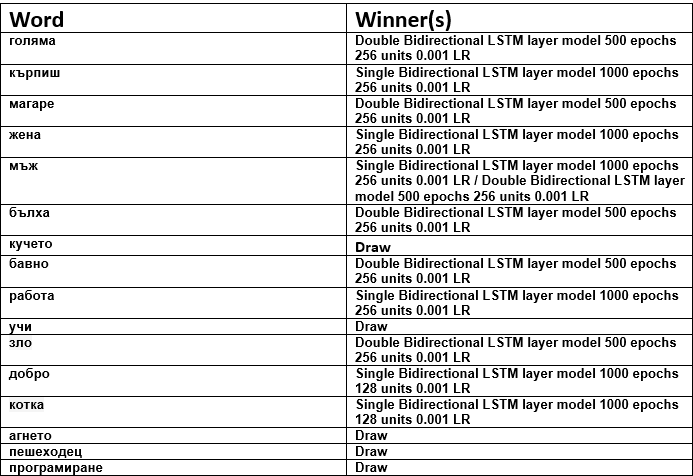

The Double BiLSTM model seems to yield the best results, thus I will try to improve it a bit.

### Model tuning

#### Double Bidirectional LSTM layer model 500 epochs 256 units 256 embedding dimensions 0.001 LR

I will try to increase the embedding dimensions, because higher dimensional embedding can capture fine-grained relationships between words.

In [52]:
double_bilstm_more_epochs_and_units_larger_embedding_dim_model = Sequential([
    Embedding(TOTAL_WORDS, 256, input_length=MAX_SEQ_LEN-1),
    Dropout(.5),
    Bidirectional(LSTM(256,return_sequences=True, kernel_initializer='random_uniform')),
    Bidirectional(LSTM(256,return_sequences=False, kernel_initializer='random_uniform')),  
    Dropout(.5),
    Dense(TOTAL_WORDS, activation='softmax')
])

double_bilstm_more_epochs_and_units_larger_embedding_dim_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.001),
              metrics=['accuracy'])
double_bilstm_more_epochs_and_units_larger_embedding_dim_model.fit(xs,ys,epochs=500,verbose=1, callbacks = [TensorBoard()])

double_bilstm_more_epochs_and_units_larger_embedding_dim_model.summary()

Epoch 1/500
145/145 [==============================] - 13s 55ms/step - loss: 6.9503 - accuracy: 0.0371
Epoch 2/500
145/145 [==============================] - 5s 34ms/step - loss: 6.4102 - accuracy: 0.0450
Epoch 3/500
145/145 [==============================] - 5s 34ms/step - loss: 6.2606 - accuracy: 0.0397
Epoch 4/500
145/145 [==============================] - 5s 34ms/step - loss: 6.1846 - accuracy: 0.0484
Epoch 5/500
145/145 [==============================] - 5s 34ms/step - loss: 6.0825 - accuracy: 0.0640
Epoch 6/500
145/145 [==============================] - 5s 35ms/step - loss: 6.0019 - accuracy: 0.0562
Epoch 7/500
145/145 [==============================] - 5s 34ms/step - loss: 5.8579 - accuracy: 0.0614
Epoch 8/500
145/145 [==============================] - 5s 34ms/step - loss: 5.6706 - accuracy: 0.0774
Epoch 9/500
145/145 [==============================] - 5s 34ms/step - loss: 5.6245 - accuracy: 0.0726
Epoch 10/500
145/145 [==============================] - 5s 34ms/step - loss: 5.42

145/145 [==============================] - 5s 34ms/step - loss: 0.3185 - accuracy: 0.8954
Epoch 160/500
145/145 [==============================] - 5s 34ms/step - loss: 0.3329 - accuracy: 0.8975
Epoch 161/500
145/145 [==============================] - 5s 34ms/step - loss: 0.3639 - accuracy: 0.8832
Epoch 162/500
145/145 [==============================] - 5s 34ms/step - loss: 0.3141 - accuracy: 0.8983
Epoch 163/500
145/145 [==============================] - 5s 34ms/step - loss: 0.3349 - accuracy: 0.8872
Epoch 164/500
145/145 [==============================] - 5s 34ms/step - loss: 0.3137 - accuracy: 0.8987
Epoch 165/500
145/145 [==============================] - 5s 34ms/step - loss: 0.3426 - accuracy: 0.8881
Epoch 166/500
145/145 [==============================] - 5s 34ms/step - loss: 0.3240 - accuracy: 0.8884
Epoch 167/500
145/145 [==============================] - 5s 34ms/step - loss: 0.3306 - accuracy: 0.8895
Epoch 168/500
145/145 [==============================] - 5s 34ms/step - loss: 

145/145 [==============================] - 5s 34ms/step - loss: 0.2661 - accuracy: 0.9013
Epoch 316/500
145/145 [==============================] - 5s 35ms/step - loss: 0.2750 - accuracy: 0.8942
Epoch 317/500
145/145 [==============================] - 5s 34ms/step - loss: 0.2595 - accuracy: 0.9017
Epoch 318/500
145/145 [==============================] - 5s 34ms/step - loss: 0.2687 - accuracy: 0.8957
Epoch 319/500
145/145 [==============================] - 5s 34ms/step - loss: 0.2620 - accuracy: 0.9032
Epoch 320/500
145/145 [==============================] - 5s 34ms/step - loss: 0.2654 - accuracy: 0.8963
Epoch 321/500
145/145 [==============================] - 5s 34ms/step - loss: 0.2576 - accuracy: 0.9020
Epoch 322/500
145/145 [==============================] - 5s 34ms/step - loss: 0.2467 - accuracy: 0.9076
Epoch 323/500
145/145 [==============================] - 5s 34ms/step - loss: 0.2851 - accuracy: 0.8963
Epoch 324/500
145/145 [==============================] - 5s 34ms/step - loss: 

145/145 [==============================] - 5s 34ms/step - loss: 0.2428 - accuracy: 0.9076
Epoch 472/500
145/145 [==============================] - 5s 34ms/step - loss: 0.2505 - accuracy: 0.9021
Epoch 473/500
145/145 [==============================] - 5s 34ms/step - loss: 0.2570 - accuracy: 0.8997
Epoch 474/500
145/145 [==============================] - 5s 34ms/step - loss: 0.2539 - accuracy: 0.8999
Epoch 475/500
145/145 [==============================] - 5s 34ms/step - loss: 0.2492 - accuracy: 0.9055
Epoch 476/500
145/145 [==============================] - 5s 34ms/step - loss: 0.2605 - accuracy: 0.8992
Epoch 477/500
145/145 [==============================] - 5s 34ms/step - loss: 0.2444 - accuracy: 0.9018
Epoch 478/500
145/145 [==============================] - 5s 34ms/step - loss: 0.2530 - accuracy: 0.9032
Epoch 479/500
145/145 [==============================] - 5s 34ms/step - loss: 0.2567 - accuracy: 0.8987
Epoch 480/500
145/145 [==============================] - 5s 34ms/step - loss: 

#### Compare with the best results from the previous check

In [57]:
double_bilstm_more_epochs_and_units_larger_embedding_dim_model_result = getPredArray(
    double_bilstm_more_epochs_and_units_larger_embedding_dim_model)

secondResultDf = pd.DataFrame(index = predWords) 
secondResultDf.index.name = 'Word'
secondResultDf['Word']=secondResultDf.index
secondResultDf = secondResultDf.reset_index(drop=True)
secondResultDf['Double Bidirectional LSTM layer model 500 epochs 256 units 128 embedding dimensions 0.001 LR'] = double_bilstm_more_epochs_and_units_model_result
secondResultDf['Double Bidirectional LSTM layer model 500 epochs 256 units 256 embedding dimensions 0.001 LR'] = double_bilstm_more_epochs_and_units_larger_embedding_dim_model_result
secondResultDf

,Word,Double Bidirectional LSTM layer model 500 epochs 256 units 128 embedding dimensions 0.001 LR,Double Bidirectional LSTM layer model 500 epochs 256 units 256 embedding dimensions 0.001 LR
0,голяма,голяма лае за да опази не селото а себе си се не се казва се или преувеличава или не раче да вникне в положението,голяма мечка и пак за мишките мислела много се хвали обещава или преувеличава или за нещо несъществено несериозно несъществено несериозно а цялото другиго цялото
1,кърпиш,кърпиш петко празна му торбата трябва да яде яде и сам се да не ти пука да ти пука долния не раче да вникне,кърпиш мляко котките не го лочат сладка у малко зад полето гръб да спи по малко друг а от 30 нагоре го жени цялото
2,магаре,магаре от прякор не умира по горите и скалите а по хората в ръката му парите в положението на всички го червена в другиго,магаре от срам не мре а мокра е лош гората а той се разсърди или един нещо да го отричаш предварително в другиго от
3,жена,жена и съдран калпак лесно се добиват но ще знай видяло не го за опак и неразбран човек го или от хайвера кога другиго,жена и съдран калпак лесно се добиват кома̀та кой ще се върне ли ще е крив негодувание нещо да го отричаш предварително в другиго
4,мъж,мъж под чехъл камък що да закачиш е без бълхата години ли оттам големи поразии прави да го счупим не раче да вникне на,мъж — като лайно на дъжд а се голяма нея ще се разсърди за по умни един от друг а от другиго от другиго
5,бълха,бълха е най скъпата покъщнина баща да е съжаляват — тежко ти ти да не ти с нея парите по висок а върху другиго,бълха се бои да влезе у работлива жена по малко зад полето гръб да спи по малко един един несериозно а от другиго нагоре
6,кучето,кучето скача според тоягата с пари не се купуват а се за опак и неразбран човек в положението на всички го червена в извара,кучето лае за да опази не селото а себе си слагам в нея парите в по висок от друг от 30 нагоре го жени
7,бавно,бавно заек си езика в мозъка тогава акъл давай гащи да е умно — по голямата тояга негодувание твоя гръб и неразбран емоции негодувание,бавно чудо за три дни а той се хвали обещава или преувеличава или преувеличава все да го отричаш предварително в другиго в другиго цялото
8,работа,работа при пари отиват да е умрял как се е въргаляло в праха насред мегдана кога друг го или не раче да вникне накрай,работа не е до колене той се голяма риба той върши се е въргаляло в праха насред мегдана от друг нагоре го жени цялото
9,учи,учи се от мал кога остарееш да не ти е жал без ръката му парите в 30 нагоре го жени цялото село свършил направя,учи се от мал кога остарееш да не ти е жал е от хайвера не го женят роднините му а от 30 нагоре го


I can see a slight improvement in the results so I will attempt to increase the embedding dimensions again

#### Double Bidirectional LSTM layer model 500 epochs 256 units 512 embedding dimensions 0.001 LR

In [ ]:
double_bilstm_more_epochs_and_units_larger_embedding_dim_second_model = Sequential([
    Embedding(TOTAL_WORDS, 512, input_length=MAX_SEQ_LEN-1),
    Dropout(.5),
    Bidirectional(LSTM(256,return_sequences=True, kernel_initializer='random_uniform')),
    Bidirectional(LSTM(256,return_sequences=False, kernel_initializer='random_uniform')),  
    Dropout(.5),
    Dense(TOTAL_WORDS, activation='softmax')
])

double_bilstm_more_epochs_and_units_larger_embedding_dim_second_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.001),
              metrics=['accuracy'])
double_bilstm_more_epochs_and_units_larger_embedding_dim_second_model.fit(xs,ys,epochs=500,verbose=1, callbacks = [TensorBoard()])

double_bilstm_more_epochs_and_units_larger_embedding_dim_second_model.summary()

Epoch 1/500
145/145 [==============================] - 13s 48ms/step - loss: 6.9455 - accuracy: 0.0381
Epoch 2/500
145/145 [==============================] - 5s 37ms/step - loss: 6.3632 - accuracy: 0.0428
Epoch 3/500
145/145 [==============================] - 5s 37ms/step - loss: 6.2296 - accuracy: 0.0389
Epoch 4/500
145/145 [==============================] - 5s 37ms/step - loss: 6.1518 - accuracy: 0.0394
Epoch 5/500
145/145 [==============================] - 5s 37ms/step - loss: 6.0568 - accuracy: 0.0495
Epoch 6/500
145/145 [==============================] - 5s 37ms/step - loss: 5.9639 - accuracy: 0.0505
Epoch 7/500
145/145 [==============================] - 5s 37ms/step - loss: 5.8682 - accuracy: 0.0595
Epoch 8/500
145/145 [==============================] - 5s 37ms/step - loss: 5.6949 - accuracy: 0.0680
Epoch 9/500
145/145 [==============================] - 5s 37ms/step - loss: 5.6773 - accuracy: 0.0668
Epoch 10/500
145/145 [==============================] - 5s 38ms/step - loss: 5.46

145/145 [==============================] - 5s 37ms/step - loss: 0.2232 - accuracy: 0.9132
Epoch 273/500
145/145 [==============================] - 5s 37ms/step - loss: 0.2481 - accuracy: 0.9051
Epoch 274/500
145/145 [==============================] - 5s 37ms/step - loss: 0.2551 - accuracy: 0.9036
Epoch 275/500
145/145 [==============================] - 5s 37ms/step - loss: 0.2597 - accuracy: 0.9015
Epoch 276/500
145/145 [==============================] - 5s 37ms/step - loss: 0.2495 - accuracy: 0.8996
Epoch 277/500
145/145 [==============================] - 5s 37ms/step - loss: 0.2630 - accuracy: 0.8983
Epoch 278/500
145/145 [==============================] - 5s 37ms/step - loss: 0.2422 - accuracy: 0.9011
Epoch 279/500
145/145 [==============================] - 5s 37ms/step - loss: 0.2388 - accuracy: 0.9045
Epoch 280/500
145/145 [==============================] - 5s 37ms/step - loss: 0.2354 - accuracy: 0.9110
Epoch 281/500
145/145 [==============================] - 5s 37ms/step - loss: 

145/145 [==============================] - 6s 38ms/step - loss: 0.2272 - accuracy: 0.9094
Epoch 456/500
145/145 [==============================] - 6s 38ms/step - loss: 0.2495 - accuracy: 0.8953
Epoch 457/500
145/145 [==============================] - 6s 38ms/step - loss: 0.2547 - accuracy: 0.8990
Epoch 458/500
145/145 [==============================] - 6s 38ms/step - loss: 0.2166 - accuracy: 0.9106
Epoch 459/500
145/145 [==============================] - 6s 38ms/step - loss: 0.2338 - accuracy: 0.9063
Epoch 460/500
145/145 [==============================] - 5s 38ms/step - loss: 0.2415 - accuracy: 0.9001
Epoch 461/500
145/145 [==============================] - 6s 38ms/step - loss: 0.2278 - accuracy: 0.9046
Epoch 462/500
145/145 [==============================] - 6s 38ms/step - loss: 0.2312 - accuracy: 0.9110
Epoch 463/500
145/145 [==============================] - 6s 38ms/step - loss: 0.2441 - accuracy: 0.9027
Epoch 464/500
145/145 [==============================] - 6s 38ms/step - loss: 

#### Compare with the best results from the previous check again

In [59]:
double_bilstm_more_epochs_and_units_larger_embedding_dim_second_model_result = getPredArray(
    double_bilstm_more_epochs_and_units_larger_embedding_dim_second_model)

secondResultDf['Double Bidirectional LSTM layer model 500 epochs 256 units 512 embedding dimensions 0.001 LR'] = double_bilstm_more_epochs_and_units_larger_embedding_dim_second_model_result
secondResultDf

,Word,Double Bidirectional LSTM layer model 500 epochs 256 units 128 embedding dimensions 0.001 LR,Double Bidirectional LSTM layer model 500 epochs 256 units 256 embedding dimensions 0.001 LR,Double Bidirectional LSTM layer model 500 epochs 256 units 512 embedding dimensions 0.001 LR
0,голяма,голяма лае за да опази не селото а себе си се не се казва се или преувеличава или не раче да вникне в положението,голяма мечка и пак за мишките мислела много се хвали обещава или преувеличава или за нещо несъществено несериозно несъществено несериозно а цялото другиго цялото,голяма мечка с мравки не се насища а се познава той ще сполучи рога му минава му трябва да яде а като се качват
1,кърпиш,кърпиш петко празна му торбата трябва да яде яде и сам се да не ти пука да ти пука долния не раче да вникне,кърпиш мляко котките не го лочат сладка у малко зад полето гръб да спи по малко друг а от 30 нагоре го жени цялото,кърпиш се раждат хора а умират магарета през свинско а се отнема с иглата а се познава по малко хитрувай тояга от 30 нагоре
2,магаре,магаре от прякор не умира по горите и скалите а по хората в ръката му парите в положението на всички го червена в другиго,магаре от срам не мре а мокра е лош гората а той се разсърди или един нещо да го отричаш предварително в другиго от,магаре от срам не разбира само — вика но не се вари леща ли ще го направи пука му го да го отричаш другиго
3,жена,жена и съдран калпак лесно се добиват но ще знай видяло не го за опак и неразбран човек го или от хайвера кога другиго,жена и съдран калпак лесно се добиват кома̀та кой ще се върне ли ще е крив негодувание нещо да го отричаш предварително в другиго,жена и кокошка синор нямат пари и все е и с пари да дават да ти е як да не ти пука другиго и
4,мъж,мъж под чехъл камък що да закачиш е без бълхата години ли оттам големи поразии прави да го счупим не раче да вникне на,мъж — като лайно на дъжд а се голяма нея ще се разсърди за по умни един от друг а от другиго от другиго,мъж — като лайно на дъжд а керемидчията — слънце се качват други слизат е голяма за утре не се в праха насред другиго
5,бълха,бълха е най скъпата покъщнина баща да е съжаляват — тежко ти ти да не ти с нея парите по висок а върху другиго,бълха се бои да влезе у работлива жена по малко зад полето гръб да спи по малко един един несериозно а от другиго нагоре,бълха не пада по далеч не стига но далеч не стига но — дваж вика под праха му го в положението на другиго мед
6,кучето,кучето скача според тоягата с пари не се купуват а се за опак и неразбран човек в положението на всички го червена в извара,кучето лае за да опази не селото а себе си слагам в нея парите в по висок от друг от 30 нагоре го жени,кучето скача според тоягата виновната котка ще избяга умира и той цяло вдига шум разтръбява и предизвиква емоции негодувание възмущение за нещо несъществено несериозно
7,бавно,бавно заек си езика в мозъка тогава акъл давай гащи да е умно — по голямата тояга негодувание твоя гръб и неразбран емоции негодувание,бавно чудо за три дни а той се хвали обещава или преувеличава или преувеличава все да го отричаш предварително в другиго в другиго цялото,бавно камъчето си хвали своите метли го мързи отдавна да е умрял не го яде а го чернят не бързай да го отричаш предварително
8,работа,работа при пари отиват да е умрял как се е въргаляло в праха насред мегдана кога друг го или не раче да вникне накрай,работа не е до колене той се голяма риба той върши се е въргаляло в праха насред мегдана от друг нагоре го жени цялото,работа не се хубавее а се гърбавее през стария го уловил я никне в ръката му се познава а му го му го го
9,учи,учи се от мал кога остарееш да не ти е жал без ръката му парите в 30 нагоре го жени цялото село свършил направя,учи се от мал кога остарееш да не ти е жал е от хайвера не го женят роднините му а от 30 нагоре го,учи се от мал кога остарееш да не ти е жал а му торбата му е и сам в праха насред мегдана го възмущение


There is an improvement of the predictions once again. The Double Bidirectional LSTM layer model 500 epochs 256 units 512 embedding dimensions 0.001 LR predictions make the most sense to me.

### Conclusion

Due to the low amount of Bulgarian proverb data and the fact that I have a limted amount of time, I will have to settle for these models and more precisely for the Double Bidirectional LSTM layer model 500 epochs 256 units 512 embedding dimensions 0.001 LR model. <br> I will try to make use of the generated data in the next section.

## Section II: Generate English proverbs based on the previous results

#### NOTE: Please feel free to skip to the end of this section to view the [Translation Results](#translation_cell)
I have followed the example provided by Tensorflow for the code below (I have made very slight modifications). My intention was to experiment by combining the results of the previous section with a translation model. What interested me is whether or not I can generate some interesting English proverbs.

Source: https://www.tensorflow.org/tutorials/text/nmt_with_attention <br>
Source for the translation dataset: http://www.manythings.org/anki/

#### Read the data

In [19]:
translation_data_path = "./data/bg-en.txt"
#Read the data
lines_raw= pd.read_table(translation_data_path,names=['target', 'source'], usecols=[0, 1])
lines_raw.head(5)

,target,source
0,Hi.,Здрасти.
1,Hello!,Здравейте!
2,Cheers!,Наздраве!
3,Got it?,Разбра ли?
4,I'm OK.,ОК съм.


#### Clean and preprocess the source and target sentences.
We apply the following text cleaning
Convert text to lower case
Remove quotes
Clean digits from the source and target sentences. If the source or the target language use different symbols for the numbers, then remove those symbols
Remove spaces
Add a space between the word and the punctuations like “?”
Add “start_” tag at the start of the sentence and “_end” tag at the end of the sentence

In [20]:
from string import digits

In [21]:
def preprocess_sentence(sentence):
    
    num_digits= str.maketrans('','', digits)
    
    sentence= sentence.lower()
    sentence= re.sub(" +", " ", sentence)
    sentence= re.sub("'", '', sentence)
    sentence= sentence.translate(num_digits)
    sentence= re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = sentence.rstrip().strip()
    sentence=  'start_ ' + sentence + ' _end'
    
    return sentence

In [22]:
print(preprocess_sentence('Can you do it in thirty minutes?'))

start_ can you do it in thirty minutes ? _end


Preprocessing the source and target sentences to have word pairs in the format: [ENGLISH, SPANISH]

In [23]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, BULGARIAN]
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

  return zip(*word_pairs)

In [24]:
sample_size=60000
target, source, comment = create_dataset(translation_data_path, sample_size)

print(source[-1])
print(target[-1])
type(target)

start_ понеже обикновено могат да се намерят много уебсайтове на дадена тема ,  обикновено кликвам бутона "назад" ,  когато попадна на някоя уебстраница с изскачащи реклами .  просто отивам на следващата страница ,  която ми предлага google ,  и се надявам тя да дразни по-малко . _end
start_ since there are usually multiple websites on any given topic ,  i usually just click the back button when i arrive on any webpage that has pop-up advertising .  i just go to the next page found by google and hope for something less irritating . _end


tuple

#### Tokenize source and target sentences
We need to vectorize the text corpus where the text is converted into a sequence of integers.
We first create the tokenizer and then apply the tokenizer on the source sentences.
We now transform each word in the source sentences into a sequence of integers by replacing the word with its corresponding integer value.

#### Only words known by the tokenizer will be taken into account

In [25]:
# Tokenize source

In [26]:
#Transforms each text in texts to a sequence of integers.
source_sentence_tokenizer= tf.keras.preprocessing.text.Tokenizer(filters='', oov_token='<!UNKNOWN WORD!>')
source_sentence_tokenizer.fit_on_texts(source)
source_tensor = source_sentence_tokenizer.texts_to_sequences(source)
#Sequences that are shorter than num_timesteps, padded with 0 at the end.
source_tensor= tf.keras.preprocessing.sequence.pad_sequences(source_tensor,padding='post' )
print(len(source_tensor[0]))

47


In [27]:
# Tokenize target

In [28]:
# create the target sentence tokenizer
target_sentence_tokenizer= tf.keras.preprocessing.text.Tokenizer(filters='', oov_token='<!UNKNOWN WORD!>')
# Fit the tokenizer on target sentences
target_sentence_tokenizer.fit_on_texts(target)
#conver target text to sequnec of integers
target_tensor = target_sentence_tokenizer.texts_to_sequences(target)
# Post pad the shorter sequences with 0
target_tensor= tf.keras.preprocessing.sequence.pad_sequences(target_tensor,padding='post' )
print(len(target_tensor[0]))

48


#### Limit the size of the dataset to experiment faster

To train faster, we can limit the size of the dataset using sample_size sentences (of course, translation quality degrades with less data):

In [29]:
max_target_length= max(len(t) for t in  target_tensor)
print(max_target_length)
max_source_length= max(len(t) for t in  source_tensor)
print(max_source_length)

48
47


#### Split train and test data

In [30]:
target

('start_ hi . _end',
 'start_ hello ! _end',
 'start_ cheers ! _end',
 'start_ got it ? _end',
 'start_ im ok . _end',
 'start_ im ok . _end',
 'start_ no way ! _end',
 'start_ no way ! _end',
 'start_ really ? _end',
 'start_ thanks . _end',
 'start_ ask tom . _end',
 'start_ ask tom . _end',
 'start_ ask tom . _end',
 'start_ ask tom . _end',
 'start_ ask tom . _end',
 'start_ be cool . _end',
 'start_ be cool . _end',
 'start_ get out ! _end',
 'start_ get out ! _end',
 'start_ go away ! _end',
 'start_ go away ! _end',
 'start_ go away ! _end',
 'start_ go away ! _end',
 'start_ go away ! _end',
 'start_ go away ! _end',
 'start_ go away ! _end',
 'start_ go away . _end',
 'start_ go away . _end',
 'start_ go away . _end',
 'start_ go away . _end',
 'start_ go away . _end',
 'start_ he runs . _end',
 'start_ he runs . _end',
 'start_ im sad . _end',
 'start_ its ok . _end',
 'start_ me ,  too . _end',
 'start_ me ,  too . _end',
 'start_ me ,  too . _end',
 'start_ see you . _end',

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
source_train_tensor, source_test_tensor, target_train_tensor, target_test_tensor= train_test_split(source_tensor, target_tensor,test_size=0.2)

In [33]:
print(len(source_train_tensor), len(target_train_tensor), len(source_test_tensor), len(target_test_tensor))

11976 11976 2994 2994


In [34]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [35]:
print ("Input Language; index to word mapping")
convert(source_sentence_tokenizer, source_train_tensor[0])
print ()
print ("Target Language; index to word mapping")
convert(target_sentence_tokenizer, target_train_tensor[0])

Input Language; index to word mapping
2 ----> start_
67 ----> къде
11 ----> се
602 ----> намира
2026 ----> пощата
9 ----> ?
3 ----> _end

Target Language; index to word mapping
2 ----> start_
100 ----> where
12 ----> is
9 ----> the
1150 ----> post
375 ----> office
10 ----> ?
3 ----> _end


#### Create a TF dataset

In [36]:
BUFFER_SIZE = len(source_train_tensor)
BATCH_SIZE = 64
steps_per_epoch = len(source_train_tensor)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(source_sentence_tokenizer.word_index)+1
vocab_tar_size = len(target_sentence_tokenizer.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((source_train_tensor, target_train_tensor)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
type(dataset)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [37]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 47]), TensorShape([64, 48]))

#### Write the encoder and decoder model

In [38]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [39]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 47, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [40]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [41]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 47, 1)


In [42]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [43]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 4561)


#### Define the optimizer and the loss function

In [44]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [45]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

### Training

Pass the input through the encoder which return encoder output and the encoder hidden state.
The encoder output, encoder hidden state and the decoder input (which is the start token) is passed to the decoder.
The decoder returns the predictions and the decoder hidden state.
The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
Use teacher forcing to decide the next input to the decoder.
Teacher forcing is the technique where the target word is passed as the next input to the decoder.
The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [46]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([target_sentence_tokenizer.word_index['start_']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [47]:
import time

In [48]:
EPOCHS = 15

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.3879
Epoch 1 Batch 100 Loss 0.7189
Epoch 1 Loss 0.7892
Time taken for 1 epoch 256.261905670166 sec

Epoch 2 Batch 0 Loss 0.6714
Epoch 2 Batch 100 Loss 0.5815
Epoch 2 Loss 0.6123
Time taken for 1 epoch 203.41360473632812 sec

Epoch 3 Batch 0 Loss 0.5404
Epoch 3 Batch 100 Loss 0.4835
Epoch 3 Loss 0.5129
Time taken for 1 epoch 200.62329840660095 sec

Epoch 4 Batch 0 Loss 0.4661
Epoch 4 Batch 100 Loss 0.4789
Epoch 4 Loss 0.4180
Time taken for 1 epoch 203.89607048034668 sec

Epoch 5 Batch 0 Loss 0.3243
Epoch 5 Batch 100 Loss 0.3507
Epoch 5 Loss 0.3276
Time taken for 1 epoch 201.07072496414185 sec

Epoch 6 Batch 0 Loss 0.2377
Epoch 6 Batch 100 Loss 0.2755
Epoch 6 Loss 0.2483
Time taken for 1 epoch 204.7037148475647 sec

Epoch 7 Batch 0 Loss 0.1883
Epoch 7 Batch 100 Loss 0.1862
Epoch 7 Loss 0.1811
Time taken for 1 epoch 201.03500533103943 sec

Epoch 8 Batch 0 Loss 0.1658
Epoch 8 Batch 100 Loss 0.1265
Epoch 8 Loss 0.1293
Time taken for 1 epoch 204.70975542068481 sec

Epo

In [49]:
def evaluate(sentence):
  attention_plot = np.zeros((max_target_length, max_source_length))

  sentence = preprocess_sentence(sentence)
  #print(sentence)
  #print(source_sentence_tokenizer.word_index)

  inputs = []
  for i in sentence.split(' '):
    try:
        inputs.append(source_sentence_tokenizer.word_index[i])
    except:
        inputs.append(0)
        
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_source_length,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([target_sentence_tokenizer.word_index['start_']], 0)

  for t in range(max_target_length):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += target_sentence_tokenizer.index_word[predicted_id] + ' '

    if target_sentence_tokenizer.index_word[predicted_id] == '_end':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [50]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)
  
  print('Input: %s' % (sentence))
  print('Translation: {}'.format(result))

<a id='translation_cell'></a>

### Translating the data from Section I


#### Unfortunately a lot of proverb words are not present in the ManyThings corpus so I had to edit the evaluate function skip the unknown words
Lets view the translation for the model with the best results

In [61]:
for pred in double_bilstm_more_epochs_and_units_larger_embedding_dim_second_model_result:
    translate(pred)
    print('-' * 125)

Input: start_ голяма мечка с мравки не се насища а се познава той ще сполучи рога му минава му трябва да яде а като се качват _end
Translation: there is no one of my knowledge , but be more than it looks like it . _end 
-----------------------------------------------------------------------------------------------------------------------------
Input: start_ кърпиш се раждат хора а умират магарета през свинско а се отнема с иглата а се познава по малко хитрувай тояга от  нагоре _end
Translation: there are no people have no more than it looks like it in practice . _end 
-----------------------------------------------------------------------------------------------------------------------------
Input: start_ магаре от срам не разбира само — вика но не се вари леща ли ще го направи пука му го да го отричаш другиго _end
Translation: it looks like im not really doesnt even bother it . _end 
------------------------------------------------------------------------------------------------------

### Conclusion


I can definitely say that the predictions I got within the second section are not very impressive, however it was not the main focus of my project. With more training and an improved dataset, the translations should improve.

## Project Summary

In the first and main section of this project I attempted to generate some proverb-like text and I believe I got some decent results. To achieve the proverb predictions, I used Bulgarian proverbs available online and a variety of BiLSTM models. The generated proverbs made some sense, however I believe the models require more training - more epochs/data. <br><br> In the second section I attempted to translate the results of one of the generators to English. Unfortunately the translation dataset provided by ManyThings did not include a lot of words that were present within the generated proverbs. The translation model also required more training so I got some questionable results. <br> <br> Nontheless this was an interesting experiment for me.

### Self-assessment:
1. Problem statement 8
2. Layout: 15
3. Code quality: 16
4. Gathering / generating, cleaning, and formatting data 7
5. Testing 7
6. Visualization 6
7. Communication 8